In [1]:
#importing data 

import requests
import pandas as pd
import json

url = "https://api.cin7.com/api/v1/SalesOrders"
query_params = {
    "rows": 250,
    "where": "createdDate<2023-02-01T00:00:00Z and createdDate>2022-12-31T23:59:59Z",
    "fields": "Reference,createdDate,FirstName, LastName, projectName,total, LineItems"
}

headers = {
    "Content-Type": "application/json"
}

auth = ("DiggsIncUS", "9901f725991a42c4b8ea12917e3c21d9")  # replace with your Cin7 username and password

data = []
page = 1
while True:
    query_params["page"] = page
    response = requests.get(url, headers=headers, params=query_params, auth=auth)
    if response.status_code == 200:
        
        # Append the data from the current page to the list of data
        data += response.json()
        # Check if there are more pages of data to fetch
        if len(response.json()) < 250:
            break
        else:
            page += 1
    else:
        print(f"Request failed with status code {response.status_code}")
        break

df = pd.json_normalize(data)


df.head()

,createdDate,reference,firstName,lastName,projectName,total,lineItems
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,"[{'id': 173662, 'createdDate': '2023-01-31T23:..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"[{'id': 173664, 'createdDate': '2023-01-31T23:..."
2,2023-01-31T23:48:27Z,114-4625906-3283437,[Redacted],[Redacted],Amazon Seller Diggs,195.00,"[{'id': 173681, 'createdDate': '2023-01-31T23:..."
3,2023-01-31T23:46:24Z,#98853,Leslie,Lantis,Shopify Diggs,464.65,"[{'id': 173660, 'createdDate': '2023-01-31T23:..."
4,2023-01-31T23:34:35Z,#98852,Brianna,Barsanti,Shopify Diggs,44.13,"[{'id': 173659, 'createdDate': '2023-01-31T23:..."


In [2]:
#df.dtypes

In [3]:
df = df.explode('lineItems')
df.head(3)

,createdDate,reference,firstName,lastName,projectName,total,lineItems
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,"{'id': 173662, 'createdDate': '2023-01-31T23:5..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173664, 'createdDate': '2023-01-31T23:5..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173665, 'createdDate': '2023-01-31T23:5..."


In [4]:
# Use json_normalize to flatten the 'lineItems' column
df_line_items = pd.json_normalize(df['lineItems'])

In [5]:
# Apply function to rename columns
df_line_items = df_line_items.rename(columns=lambda x: x.split(".")[-1])


In [6]:
df.head(3)

,createdDate,reference,firstName,lastName,projectName,total,lineItems
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,"{'id': 173662, 'createdDate': '2023-01-31T23:5..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173664, 'createdDate': '2023-01-31T23:5..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173665, 'createdDate': '2023-01-31T23:5..."


In [7]:
df = df.reset_index(drop=True)
# Combine the flattened 'lineItems' DataFrame with the original DataFrame
df = pd.concat([df, df_line_items], axis=1)

In [8]:
df.head(3)

,createdDate,reference,firstName,lastName,projectName,total,lineItems,id,createdDate,transactionId,...,sizeCodes,lineComments,unitCost,unitPrice,discount,qtyShipped,holdingQty,accountCode,stockControl,stockMovements
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,"{'id': 173662, 'createdDate': '2023-01-31T23:5...",173662.0,2023-01-31T23:57:15Z,78808.0,...,NaN,None,42.9700,185.25,0.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173664, 'createdDate': '2023-01-31T23:5...",173664.0,2023-01-31T23:56:06Z,78809.0,...,NaN,None,41.4259,150.00,15.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
2,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,"{'id': 173665, 'createdDate': '2023-01-31T23:5...",173665.0,2023-01-31T23:56:06Z,78809.0,...,NaN,None,3.3760,34.00,3.4,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."


In [9]:
# Drop the original 'lineItems' column
df_data = df.drop('lineItems', axis=1)


In [11]:
##print(df_data.dtypes)

In [12]:
# rename the columns
df_data = df_data.rename(columns={'createdDate': 'SalesOrder_createdDate',
                        'reference': 'SalesOrder_reference',
                        'firstName': 'SalesOrder_firstName',
                        'lastName': 'SalesOrder_lastName',
                        'projectName': 'SalesOrder_projectName',
                        'total': 'SalesOrder_total'})
df_data.head(3)
#raw data is ready!

,SalesOrder_createdDate,SalesOrder_reference,SalesOrder_firstName,SalesOrder_lastName,SalesOrder_projectName,SalesOrder_total,id,SalesOrder_createdDate,transactionId,parentId,...,sizeCodes,lineComments,unitCost,unitPrice,discount,qtyShipped,holdingQty,accountCode,stockControl,stockMovements
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,173662.0,2023-01-31T23:57:15Z,78808.0,0.0,...,NaN,None,42.9700,185.25,0.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,173664.0,2023-01-31T23:56:06Z,78809.0,0.0,...,NaN,None,41.4259,150.00,15.0,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."
2,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,173665.0,2023-01-31T23:56:06Z,78809.0,0.0,...,NaN,None,3.3760,34.00,3.4,1.0,0.0,,FIFO,"[{'batch': None, 'quantity': 1.0, 'serial': No..."


In [13]:
# Remove unwanted columns
df_data = df_data.drop(['parentId', 'productOptionId', 'integrationRef', 'sort', 'sizeCodes', 'lineComments', 'holdingQty', 'accountCode', 'stockControl', 'stockMovements'], axis=1)

df_data.head(3)


,SalesOrder_createdDate,SalesOrder_reference,SalesOrder_firstName,SalesOrder_lastName,SalesOrder_projectName,SalesOrder_total,id,SalesOrder_createdDate,transactionId,productId,...,option1,option2,option3,qty,styleCode,barcode,unitCost,unitPrice,discount,qtyShipped
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,173662.0,2023-01-31T23:57:15Z,78808.0,172.0,...,Grey,OS,,1.0,TRV001AOSG,842469000562,42.9700,185.25,0.0,1.0
1,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,173664.0,2023-01-31T23:56:06Z,78809.0,165.0,...,Grey,L,,1.0,PAD018AALG,842469000302,41.4259,150.00,15.0,1.0
2,2023-01-31T23:56:06Z,#98854,Philip,Kent,Shopify Diggs,836.90,173665.0,2023-01-31T23:56:06Z,78809.0,192.0,...,Ice,OS,,1.0,GRO010AASIR,842469000814,3.3760,34.00,3.4,1.0


In [14]:
print(df_data.columns)

Index(['SalesOrder_createdDate', 'SalesOrder_reference',
       'SalesOrder_firstName', 'SalesOrder_lastName', 'SalesOrder_projectName',
       'SalesOrder_total', 'id', 'SalesOrder_createdDate', 'transactionId',
       'productId', 'code', 'name', 'option1', 'option2', 'option3', 'qty',
       'styleCode', 'barcode', 'unitCost', 'unitPrice', 'discount',
       'qtyShipped'],
      dtype='object')


In [44]:
#Mapping products from excel file


#import excel file

sku_mapping_df = pd.read_excel('/Users/revatirameshkharate/Desktop/ITP Projects/Diggs BI/Diggs SKU Mapping.xlsx', sheet_name='Sheet1')
sku_mapping_df.head()




,Diggs SKU,Product Title,Variant,Category,Color,Size,Is Bundle?,Component 1,Component 2,Component 3,Component 4
0,WSC007AALW,Collar,Collar - Large - Ash,Walk,Ash,Large,N,NaN,NaN,NaN,NaN
1,WSC012AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,N,NaN,NaN,NaN,NaN
2,WSC040AALP,Collar,Collar - Large - Blush,Walk,Blush,Large,N,NaN,NaN,NaN,NaN
3,WSC008AALB,Collar,Collar - Large - Charcoal,Walk,Charcoal,Large,N,NaN,NaN,NaN,NaN
4,WSC016AALL,Collar,Collar - Large - Lilac,Walk,Lilac,Large,N,NaN,NaN,NaN,NaN


In [45]:
#mergeing
sku_mapping_df.rename(columns = {'Diggs SKU':'styleCode'}, inplace = True)

master_data = pd.merge(df_data, sku_mapping_df, on='styleCode')

In [46]:
master_data.head()

,SalesOrder_createdDate,SalesOrder_reference,SalesOrder_firstName,SalesOrder_lastName,SalesOrder_projectName,SalesOrder_total,id,SalesOrder_createdDate,transactionId,productId,...,Product Title,Variant,Category,Color,Size,Is Bundle?,Component 1,Component 2,Component 3,Component 4
0,2023-01-31T23:57:15Z,#98855,Leslie,Krom,Shopify Diggs,204.24,173662.0,2023-01-31T23:57:15Z,78808.0,172.0,...,Passenger,Passenger - Grey,Travel,Grey,NaN,N,NaN,NaN,NaN,NaN
1,2023-01-30T02:46:05Z,#98647,Stacy,Vial,Shopify Diggs,204.33,172811.0,2023-01-30T02:46:05Z,78493.0,172.0,...,Passenger,Passenger - Grey,Travel,Grey,NaN,N,NaN,NaN,NaN,NaN
2,2023-01-29T15:48:05Z,#98594,Jennifer,Carlson,Shopify Diggs,185.11,172633.0,2023-01-29T15:48:05Z,78421.0,172.0,...,Passenger,Passenger - Grey,Travel,Grey,NaN,N,NaN,NaN,NaN,NaN
3,2023-01-26T18:31:13Z,#98340,Duniesky,Fernandez,Shopify Diggs,197.80,171645.0,2023-01-26T18:31:13Z,78035.0,172.0,...,Passenger,Passenger - Grey,Travel,Grey,NaN,N,NaN,NaN,NaN,NaN
4,2023-01-25T21:27:00Z,SCAR31186-1,Summer,Cartwright,Influencers,225.00,171481.0,2023-01-25T21:27:00Z,77966.0,172.0,...,Passenger,Passenger - Grey,Travel,Grey,NaN,N,NaN,NaN,NaN,NaN


In [49]:
#grouping on master data

# group by products sold
product_sales = master_data.groupby('Product Title')['qty'].sum().sort_values(ascending=False)

product_sales_df = product_sales.to_frame()
product_sales_df.head()

#top 20 products
product_sales_top20 = product_sales_df.head(20)
product_sales_top20.head(2)



,qty
Product Title,
Revol,2993.0
Groov,2271.0


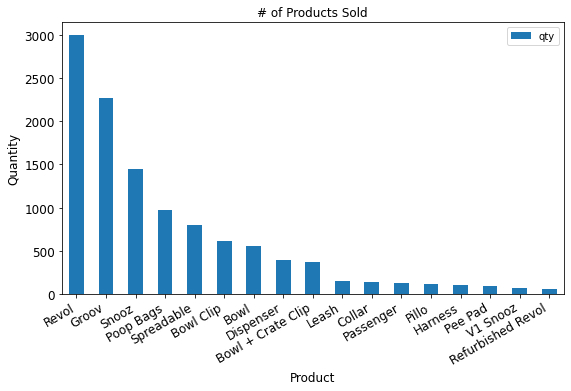

In [50]:
fig1 = product_sales_top20.plot(kind = 'bar', title ="# of Products Sold", figsize=(9, 5), legend=True, fontsize=12)

fig1.set_xlabel("Product", fontsize=12)
fig1.set_ylabel("Quantity", fontsize=12)
plt.xticks(rotation=30, ha = 'right')
plt.show()


In [51]:
# group by products price
product_salesprice = master_data.groupby('Product Title')['SalesOrder_total'].sum().sort_values(ascending=False)

product_salesprice_df = product_salesprice.to_frame()
product_salesprice_df.head()

#top 20 products
product_salesprice_top20 = product_salesprice_df.head(20)
product_salesprice_top20.head(2)



,SalesOrder_total
Product Title,
Revol,1771689.36
Snooz,630944.58


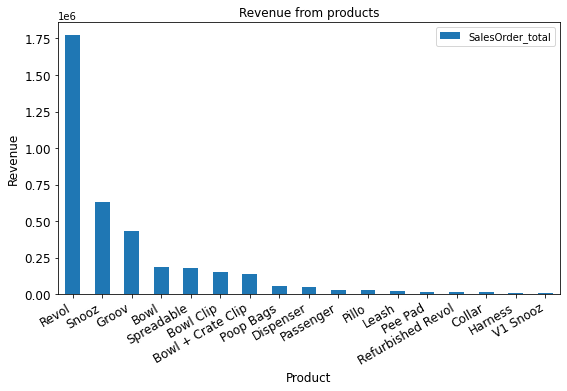

In [52]:
# Plotting the pie chart for above dataframe 
#revenue
fig2 = product_salesprice_top20.plot(kind='bar', title = 'Revenue from products', y='SalesOrder_total', figsize=(9, 5), legend=True, fontsize=12)

fig2.set_xlabel("Product", fontsize=12)
fig2.set_ylabel("Revenue", fontsize=12)
plt.xticks(rotation=30, ha = 'right')
plt.show()